In [1]:
import numpy as np
from io import StringIO
import time,os, importlib
from tqdm import tqdm
np.set_printoptions(linewidth=160)
import lib.ktn_io as kio
import lib.gt_tools as gt

from lib.sampler import sampler as KTNsampler
from lib.aib_system import aib_system

from scipy.sparse import save_npz,load_npz, diags, eye, csr_matrix,bmat,find
from scipy.sparse.linalg import eigs,inv,spsolve
from scipy.sparse.csgraph import connected_components
import scipy as sp
import scipy.linalg as spla
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.colors import LogNorm


Using tqdm package for pretty progress bars!


# Load Data

0
NA, NB, NI: 5 128 767
276
kk 5 128

path: 0 -> 521 -> 12 -> 10


path: 10 -> 7 -> 528 -> 0

INITIAL SAMPLE DONE : found 65/1004 pairs; 939 remaining


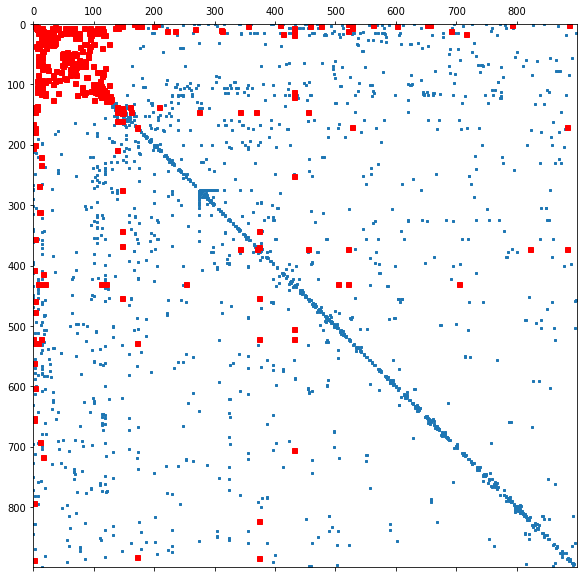

In [2]:
data_dir = "KTN_data/LJ38/4k_proc/"

gt_check = False
generate = False
beta = 10.0 # overwritten if generate = False
Emax = None
sys = aib_system(path=data_dir,beta=beta,generate=generate,Emax=Emax)
selA,selB = kio.load_AB(data_dir,np.ones(sys.N,bool))

sys.define_AB_regions(selA,selB)
print("kk",selA.sum(),sys.selB.sum())



""" true density """
true_dense = float(sys.K.nnz) / float(sys.K.shape[0]*sys.K.shape[1])

""" Initialize sampler """
sampler = KTNsampler(sys)

depth=4
limit=4
path, path_region = sys.find_path(sys.f[sys.selA].argmin(),sys.f[sys.selB].argmin(),depth=depth,limit=limit,strategy="DNEB")
path_r, path_region_r = sys.find_path(sys.f[sys.selB].argmin(),sys.f[sys.selA].argmin(),depth=depth,limit=limit,strategy="DNEB")

sampler.initial_sample_path_region(np.arange(sys.N)[path_region+path_region_r],ncs=10)

plt.figure(figsize=(10,10))

plt.spy(sampler.sys.K,markersize=2.0)
plt.spy(sampler.sys.rK,markersize=5.0,c='r')
plt.show()

In [3]:

bab,gterr = sampler.new_true_branching_probability()

""" open output file """
name = data_dir.split("/")[-1-int(data_dir[-1]=="/")]
ff = open('output/pab_converge_%s' % name,'w')

nscycles = 1
ncycles = 2
npairs = 100
ssnpairs = 50
ss = 0 # >0 if we do single ended search

rK = sampler.sys.rK.copy()
sampler.sys.rK = sampler.sys.K.copy()
pp,res = sampler.sample(npairs=npairs,ss=ss) # sampling process. Returns
bab = res['ebab'].copy()
sampler.sys.rK = rK.copy()


print("{: <4} {: <10} {: <10} {: <10} {: <10} {: <10} {: <10}".format(
"iter","estimated bp","expected bp","expected +","expected -","SingleEnded?","true bp"))

ebab=0.0

for jj in range(nscycles):
    se=0
    pbar=tqdm(total=ncycles,miniters=0,leave=True)
    for ii in range(ncycles):

        orp = sampler.remaining_pairs() # DIVINE INFORMATION- number of remaining pairs

        # sampling process returns pp = number of pairs, sens = vector of various net sensitivities and found sparsity, ebab = predicted branching probability (to be compared to bab)
        
        pp,res = sampler.sample(npairs=npairs,ss=ss) # sampling process. Returns

        nrp = sampler.remaining_pairs() # DIVINE INFORMATION- number of remaining pairs

        probe_compl = float(sampler.probed.sum()) / float(sampler.sys.K.shape[0]*sampler.sys.K.shape[1])
        
        ff.write("%d %d %10.10g %10.10g " % (ii,nrp,probe_compl,res['ebab']))
        for key in ['TotalMaxMin','SingleMaxMin','ExpectMaxMin']:
            ff.write("%10.10g %10.10g " % (res[key][0],res[key][1]))
        ff.write("%10.10g %10.10g\n" % (res['Sparsity'],bab))
        
        ebab = res['ebab']/bab
        
        tmm = [res['TotalMaxMin'][0]/bab,res['TotalMaxMin'][1]/bab]
                
        pbar.update(1)
    pbar.close()
    
    print("{: <4} {: <10} ".format("%d" % ii,"%1.4g" % ebab),end="")
    print("{: <10} {: <10} {: <10}".format("%1.4g" % tmm[0],"%1.4g" % tmm[1],"%1.4g" % (tmm[0]+tmm[1])))
          
ff.close()


DIRECT =  0 + 0.002451 = 0.002451
GT = 0.002451 +  0 = 0.002451


  0%|          | 0/2 [00:00<?, ?it/s]

iter estimated bp expected bp expected + expected - SingleEnded? true bp   


100%|██████████| 2/2 [00:00<00:00,  2.05it/s]

1    0.1097     2.817e+10  -7.901e+07 2.809e+10 
